# Primer on using odc-stac/odc-geo

With the new releases of `odc-geo` and `odc-stac` there are a lot of new features that make working with geospatial data in a notebook much more pleasant and productive. This notebook walks through some of the features

```bash
pip install odc-geo==0.2.0 odc-stac==0.3.0
# OR
mambba install odc-geo==0.2.0 odc-stac==0.3.0
```

This notebook was tested on [Planetary Computer Hub](https://planetarycomputer.microsoft.com/). It loads 16-days worth of Landsat8 scenes in a UTM zone 33 (covers parts of Europe and Africa). Imagery is loaded at 1km per pixel resolution in Web Mercator projection. We convert pixels to `RGBA<uint8>` by clipping `6_000, 30_000 -> 0, 255` and display result on the map.

You can download [this notebook](odc-stac-demo.ipynb) to try it out on your own.

In [1]:
%pip install planetary-computer

Note: you may need to restart the kernel to use updated packages.


## Query STAC Items

Query 16 days at the start of June 2021. Landsat 8 revisit is 16 days so we should get one observation from each scene in the queried region.

In [2]:
import pystac_client

catalog = pystac_client.Client.open("https://planetarycomputer.microsoft.com/api/stac/v1")

items_all = catalog.search(
    collections=["landsat-8-c2-l2"],
    datetime="2021-06-01T00:00:00Z/2021-06-16T23:59:59Z",
    bbox=[10, -71, 21, 71],
).get_all_items()

# only keep items in utm=33, to select one tall column of data
items = [item for item in items_all if item.properties["proj:epsg"] in [32633, 32733]]
print(f"Using {len(items)} of {len(items_all)} items (utm 33)")

Using 272 of 605 items (utm 33)


## Construct Dask Graph

Request to load data with `odc.stac.load`.

- Only load `red`,`green`,`blue` bands
- 1km sized pixels in Web Mercator projection (`EPSG:3857`)
- Specify `uint16` pixels `0` marking nodata pixels (this can also be extracted from STAC extension data if configured)
- Use `average` resampling for converting to desired projection
- Put all items into one pixel plane, using custom groupby (`groupby=`)
  - Most of the time you'll use `groupby="time"` or `groupby="solar_day"`
- Configure Dask chunking parameters and enable delayed computation (default is to load directly) `chunks=`
  - This data is tall an narrow so we only chunk tall dimension
- Supply url signing function `patch_url=planetary_computer.sign`
  - Data is publicly accessible, but requests need to be signed
- Convert to RGBa, replacing missing data with transparent pixels

No pixel loading happens yet, this just builds a recipe that we will execute later on.

In [3]:
import planetary_computer
from dask.distributed import Client
from odc.stac import configure_rio
from odc.stac import load as stac_load

configure_rio(cloud_defaults=True)  # No need to look for side-car files

# fmt: off
xx = stac_load(
    items,
    ["red", "green", "blue"],  # Can be omited, then you'll get all the bancs
    #################################################################
    # All options below have reasonable defaults derived
    # from supplied metadata.
    #################################################################
    
    crs="epsg:3857",       # Defaults to most common CRS across Items
    resolution=1000,       # Defaults to native resolution

    dtype="uint16",        # Defaults to native pixel type
    nodata=0,              # Defaults to native
    
    resampling="average",  # Default is `nearest`
    
    # Default is to group by time
    # groupby="solar_day", # is often what one wants
    groupby=lambda item, parsed, idx: 1, # all items in the same "group"
    
    # Enable and configure Dask
    # since each pixel is 1x1km we opt for smaller chunk sizes
    # Image will be Tall and narrow, so only chunk along Y
    chunks={"x": -1, "y": 1000},
    
    # Needed for planetary computer data sources
    patch_url=planetary_computer.sign,
)
# fmt: on

thumb = xx.odc.to_rgba(vmin=6_000, vmax=30_000)

display(xx)
display(thumb)

<xarray.Dataset>
Dimensions:      (y: 51263, x: 40075, time: 1)
Coordinates:
  * y            (y) float64 1.133e+07 1.132e+07 ... -3.994e+07 -3.994e+07
  * x            (x) float64 -2.004e+07 -2.004e+07 ... 2.004e+07 2.004e+07
    spatial_ref  int32 3857
  * time         (time) datetime64[ns] 2021-06-01T09:38:46.486871
Data variables:
    red          (time, y, x) uint16 dask.array<chunksize=(1, 1000, 40075), meta=np.ndarray>
    green        (time, y, x) uint16 dask.array<chunksize=(1, 1000, 40075), meta=np.ndarray>
    blue         (time, y, x) uint16 dask.array<chunksize=(1, 1000, 40075), meta=np.ndarray>

<xarray.DataArray 'ro_rgba-aa631fd2c55d4d0ebdea3743817df027-5012041ba9a0f08e2ff89db3c65f2514' (
                                                                                               time: 1,
                                                                                               y: 51263,
                                                                                               x: 40075,
                                                                                               band: 4)>
dask.array<ro_rgba-aa631fd2c55d4d0ebdea3743817df027, shape=(1, 51263, 40075, 4), dtype=uint8, chunksize=(1, 1000, 40075, 4), chunktype=numpy.ndarray>
Coordinates:
  * y            (y) float64 1.133e+07 1.132e+07 ... -3.994e+07 -3.994e+07
  * x            (x) float64 -2.004e+07 -2.004e+07 ... 2.004e+07 2.004e+07
    spatial_ref  int32 3857
  * time         (time) datetime64[ns] 2021-06-01T09:38:46.486871
  * band         (band) <U1 'r' 'g' 'b' 'a'

In [4]:
# Start local Dask client to run across CPUs
#  one can also connect to remote cluster
dask_client = Client()

### Actually Load and Convert to RGBA

Should take about a minute, longer if running from "home".

In [5]:
%%time
thumb = thumb.compute()

2023-06-07 20:27:55,704 - distributed.worker - WARNING - Compute Failed
Key:       ('red-d9111fdb43a613f28a9e159e10c15728', 0, 9, 0)
Function:  _dask_loader_tyx
args:      ([RasterSource(uri='https://landsateuwest.blob.core.windows.net/landsat-c2/level-2/standard/oli-tirs/2021/187/046/LC08_L2SP_187046_20210603_20210608_02_T1/LC08_L2SP_187046_20210603_20210608_02_T1_SR_B4.TIF?st=2023-06-06T20%3A14%3A06Z&se=2023-06-07T20%3A59%3A06Z&sp=rl&sv=2021-06-08&sr=c&skoid=c85c15d6-d1ae-42d4-af60-e2ca0f81359b&sktid=72f988bf-86f1-41af-91ab-2d7cd011db47&skt=2023-06-07T19%3A03%3A12Z&ske=2023-06-14T19%3A03%3A12Z&sks=b&skv=2021-06-08&sig=zcs/4m%2BZ42ldZuemncw6dPSoLYBBoRM5FYmDsyR50dY%3D', band=1, subdataset=None, geobox=None, meta=None), RasterSource(uri='https://landsateuwest.blob.core.windows.net/landsat-c2/level-2/standard/oli-tirs/2021/187/047/LC08_L2SP_187047_20210603_20210608_02_T1/LC08_L2SP_187047_20210603_20210608_02_T1_SR_B4.TIF?st=2023-06-06T20%3A14%3A06Z&se=2023-06-07T20%3A59%3A06Z&sp=rl&sv=20

WarpOperationError: Chunk and warp failed

## Plot Color Image on a Map

We use `folium` here, but same works with `ipyleaflet` too.

**note**: we are using `webp` compression here to reduce size of rendered notebook. If you don't see an image on a map below it could be that your browser doesn't support webp.

In [6]:
import folium

_map = folium.Map()
# fmt: off
thumb.odc.add_to(
    _map,
    fmt="webp",        # Default is png, jpeg is also supported
    quality=60,        # webp/jpeg quality configuration
    max_size=10_000,  # disable further shrinking, keep 1km resolution
    opacity=0.90,      # folium layer options are passed-through
)
# fmt: on
_map.fit_bounds(thumb.odc.map_bounds())
display(_map)

## Add Metadata to the Map

We can also use `geopandas` to plot stac item metadata on top of imagery. Handy for narrowing down test scenes when looking for experiment sites.

In [7]:
import geopandas
import pystac

items = pystac.ItemCollection(sorted(items, key=lambda x: x.datetime), clone_items=False)
df = geopandas.GeoDataFrame.from_features(items.to_dict(), crs="epsg:4326")
# https://github.com/geopandas/geopandas/issues/1208
df["id"] = [x.id for x in items]
df[["geometry", "id", "datetime", "landsat:wrs_path", "landsat:wrs_row", "proj:epsg"]].explore(
    "landsat:wrs_path",
    style_kwds=dict(fillOpacity=0, width=0.3, opacity=0.3),
    popup=True,
    categorical=True,
    m=_map,
)
display(_map)

## Review Single Scene

Let's have a closer look at one scene in Africa.

In [8]:
items_179_073 = [
    item
    for item in items
    if (item.properties["landsat:wrs_path"], item.properties["landsat:wrs_row"]) == ("179", "073")
]
items_179_073

[<Item id=LC08_L2SP_179073_20210611_02_T1>]

### Load without using Dask

If `chunks=` parameter is not supplied data loading happens locally without using Dask. Concurrency is still suported though, we request to use 4 CPU cores with `pool=4`. Progress can be observed by passing `progress=tqdm` option.

  0%|          | 0/64 [00:00<?, ?it/s]

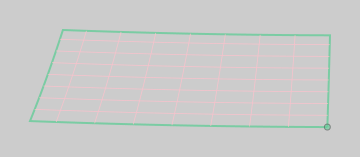

In [9]:
from IPython.display import Image
from tqdm.auto import tqdm

yy = stac_load(
    items_179_073,
    ["red", "green", "blue", "nir08"],
    dtype="uint16",
    nodata=0,
    patch_url=planetary_computer.sign,
    pool=4,
    progress=tqdm,
)

# display raster GeoBox
# - Loaded in Native projection/resolution
yy.odc.geobox

### Generate Preview

- Convert to RGBA
- Shrink image to have no more than 1600 pixels per side using `cubic` resampling
- Compress with `jpeg` and display
  - `jpeg` does not support transparency so we ask for missing pixels to be white
  - Default is `png` that does support transparency and is lossless, but is more heavy in terms of bytes
  - Use `webp` when size matters but transparency is also needed (some browsers might not support it though)

In [10]:
#Image(
#    data=yy.odc.to_rgba(vmin=6_000, vmax=30_000)
#    .isel(time=0)
#    .odc.reproject(yy.odc.geobox.zoom_to(1600), resampling="cubic")
#    .odc.compress("jpeg", 90, transparent=(255, 255, 255))
#)

### Visualize NIR band

Individual bands can be visualized in false colour with `.odc.colorize` method (supports matplotlib colormaps).

/srv/conda/envs/notebook/lib/python3.10/site-packages/odc/geo/_rgba.py:188: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(x)
/srv/conda/envs/notebook/lib/python3.10/site-packages/odc/geo/_rgba.py:191: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(x)


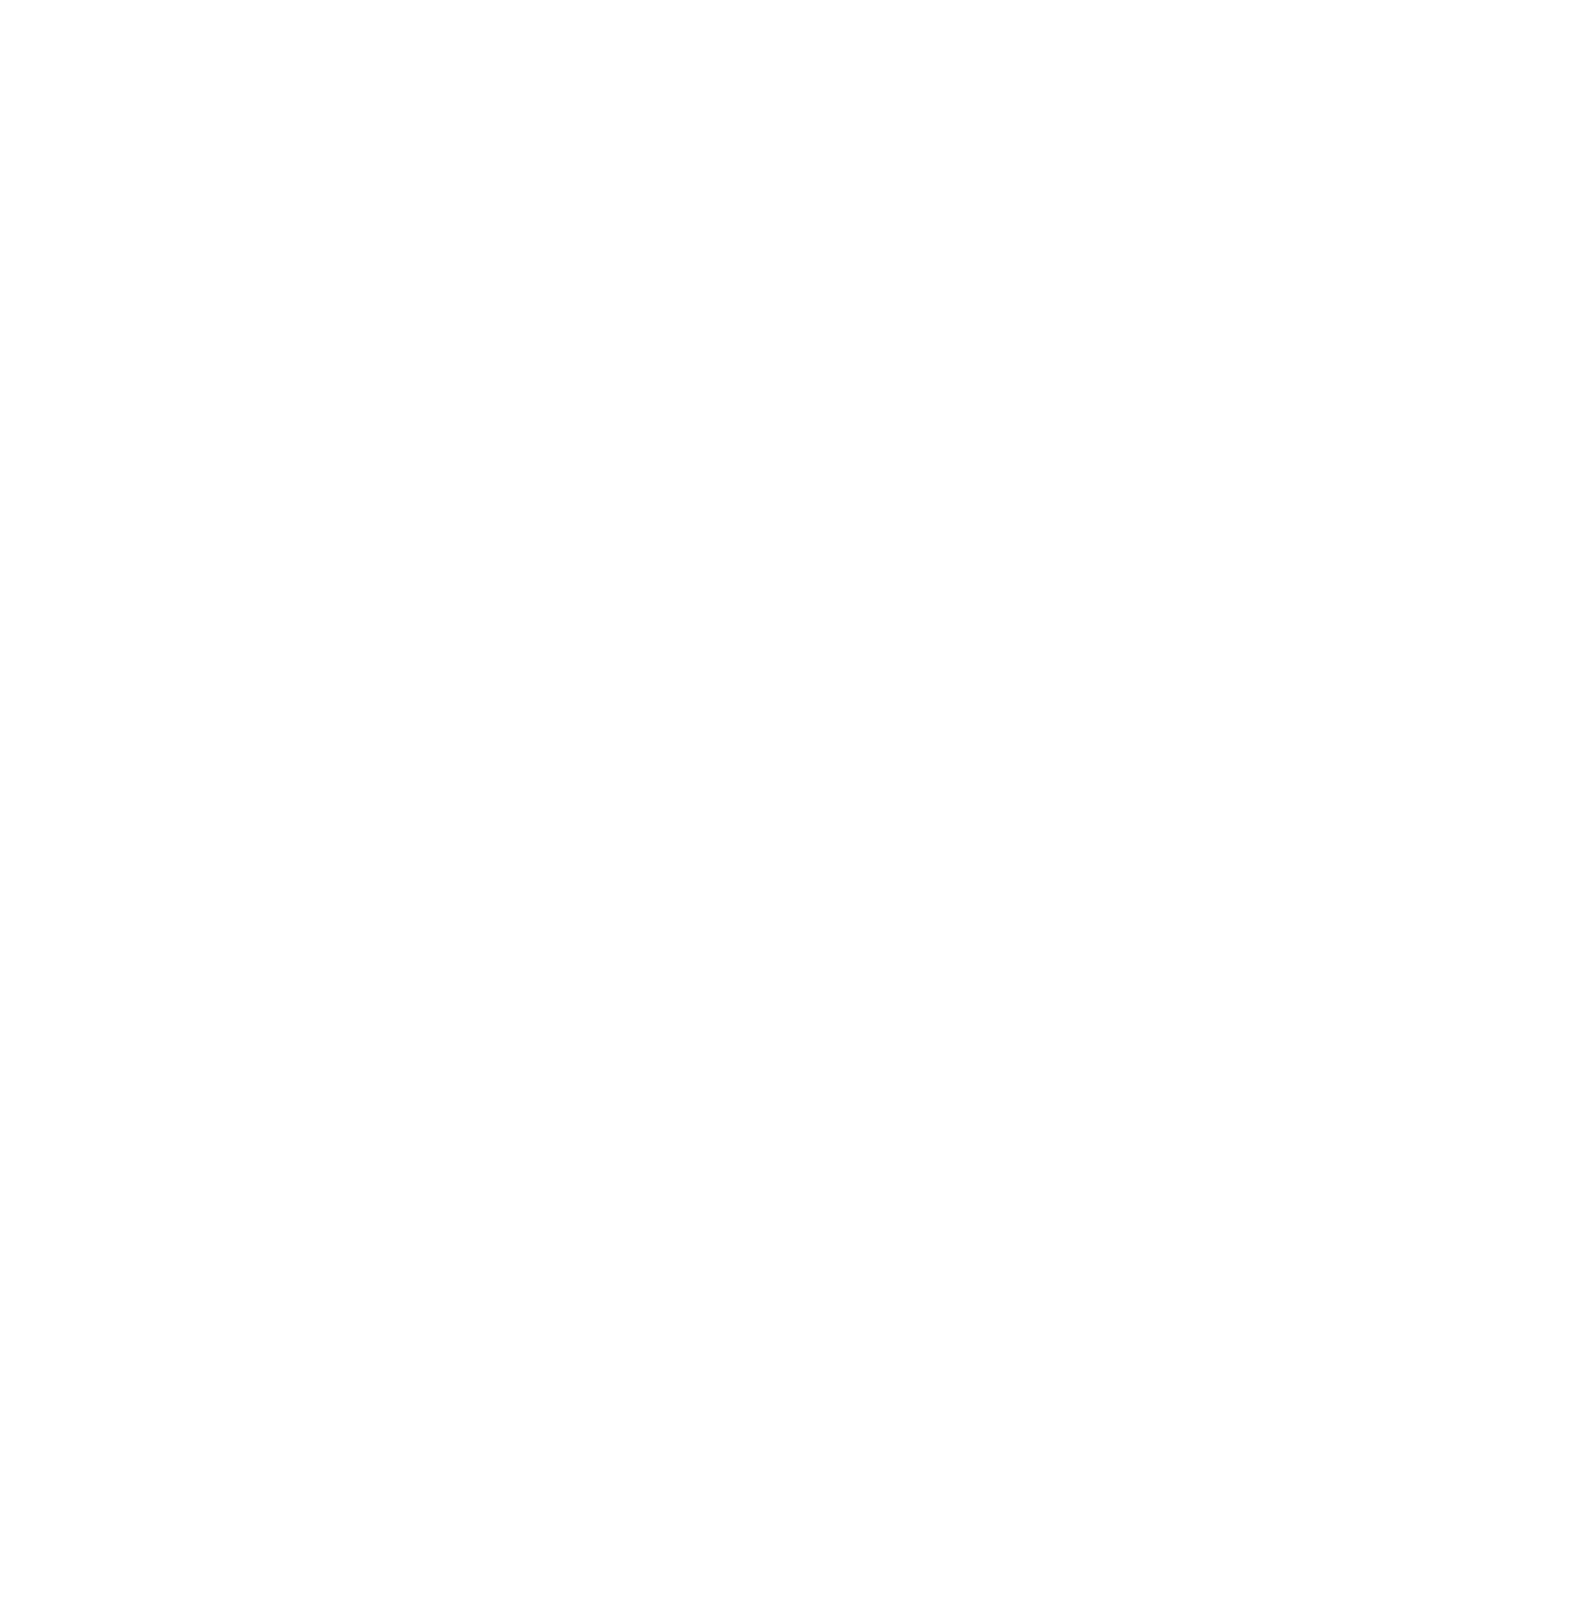

In [11]:
nir = yy.isel(time=0).nir08
Image(
    data=nir.odc.reproject(yy.odc.geobox.zoom_to(1600), resampling="cubic")
    .odc.colorize("magma")
    .odc.compress("webp", 80)
)

### Save Images to GeoTIFF

Cloud Optimized GeoTIFF (COG) is a popular and well supported format. We can easily save xarrays to COG format.

In [12]:
fname_rgb = f"{items_179_073[0].id}-rgba-cog.tif"
fname_nir = f"{items_179_073[0].id}-nir-cog.tif"

print(f"Saving {fname_rgb}")
yy.isel(time=0).odc.to_rgba(vmin=6_000, vmax=30_000).odc.write_cog(
    fname_rgb,
    overwrite=True,
    overview_resampling="average",
    # there are other options, but we'll leave them as defaults
)

print(f"Saving {fname_nir}")
nir.odc.write_cog(
    fname_nir,
    overwrite=True,
    overview_resampling="average",
    # change compression to ZSTD (default is DEFLATE)
    compress="zstd",
    zstd_level=9,
)
print("Done")

Saving LC08_L2SP_179073_20210611_02_T1-rgba-cog.tif
Saving LC08_L2SP_179073_20210611_02_T1-nir-cog.tif
Done


In [13]:
!ls -lh {fname_rgb} {fname_nir}
!gdalinfo {fname_rgb}
!gdalinfo {fname_nir}

-rw-r--r-- 1 jovyan jovyan  18K Jun  7 20:31 LC08_L2SP_179073_20210611_02_T1-nir-cog.tif
-rw-r--r-- 1 jovyan jovyan 367K Jun  7 20:31 LC08_L2SP_179073_20210611_02_T1-rgba-cog.tif
Driver: GTiff/GeoTIFF
Files: LC08_L2SP_179073_20210611_02_T1-rgba-cog.tif
Size is 7682, 7792
Coordinate System is:
PROJCRS["WGS 84 / UTM zone 33S",
    BASEGEOGCRS["WGS 84",
        DATUM["World Geodetic System 1984",
            ELLIPSOID["WGS 84",6378137,298.257223563,
                LENGTHUNIT["metre",1]]],
        PRIMEM["Greenwich",0,
            ANGLEUNIT["degree",0.0174532925199433]],
        ID["EPSG",4326]],
    CONVERSION["UTM zone 33S",
        METHOD["Transverse Mercator",
            ID["EPSG",9807]],
        PARAMETER["Latitude of natural origin",0,
            ANGLEUNIT["degree",0.0174532925199433],
            ID["EPSG",8801]],
        PARAMETER["Longitude of natural origin",15,
            ANGLEUNIT["degree",0.0174532925199433],
            ID["EPSG",8802]],
        PARAMETER["Scale factor at

---------------------------------

## Dump Versions

In [14]:
import odc.geo
import odc.stac

print(f"odc.stac=={odc.stac.__version__}")
print(f"odc.geo=={odc.geo.__version__}")

odc.stac==0.3.6
odc.geo==0.4.0
